In [1]:
import skvideo.io
import skvideo.datasets
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [3]:
videodata = skvideo.io.vread("1.mp4", outputdict={"-pix_fmt": "gray"})
print(videodata.shape)

(1208, 720, 404, 1)


# Brightness signal computation

In [4]:
brightness = np.zeros((len(videodata)))
for i in range(len(videodata)):
    frame = videodata[i]
    brightness[i] = sum(frame) / (frame.shape[0] * frame.shape[1])

print(brightness)

[ 56.05909653  56.22029703  56.37706958 ...,  55.68894046  55.75019252
  55.84078658]


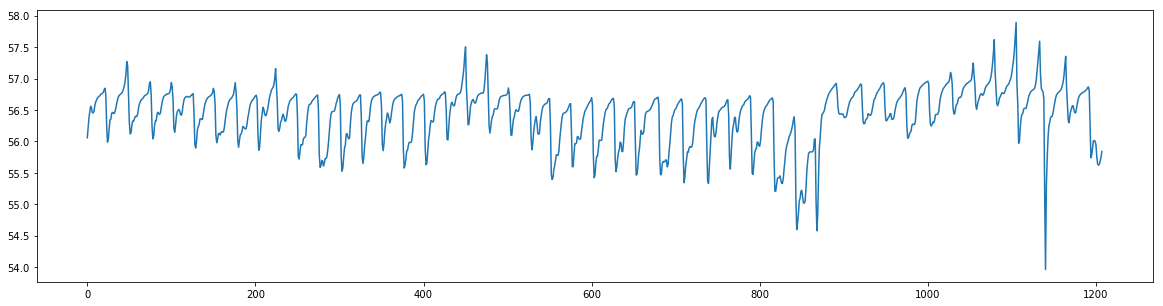

In [39]:
plt.figure(figsize=(20,5))
plt.plot(list(range(len(brightness))), brightness)
plt.show()

# Band-pass filtering

In [24]:
BPM_L = 40;    # Heart rate lower limit [bpm]
BPM_H = 230;   # Heart rate higher limit [bpm]
FILTER_STABILIZATION_TIME = 1;    # [seconds]
# Butterworth frequencies must be in [0, 1], where 1 corresponds to half the sampling rate
b, a = signal.butter(2, [((BPM_L / 60) / 30 * 2), ((BPM_H / 60) / 30 * 2)], 'bandpass');
print(b,a)
print("Brightness ::")
print(brightness)
filtBrightness = filter([b, a], brightness)
print("After Brightness ::")
# print((filtBrightness))
print(list(filter([b, a], brightness)))
# Cut the initial stabilization time
# filtBrightness = filtBrightness((v.FrameRate * FILTER_STABILIZATION_TIME + 1):size(filtBrightness, 2));

[ 0.07384643  0.         -0.14769287  0.          0.07384643] [ 1.         -2.91940387  3.31043327 -1.77614788  0.39339963]
Brightness ::
[ 56.05909653  56.22029703  56.37706958 ...,  55.68894046  55.75019252
  55.84078658]
After Brightness ::


TypeError: 'list' object is not callable